## Autoencoder

In [1]:
from keras.datasets import cifar10
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, Flatten, Dropout
from keras.models import Model
from keras import backend as K
import keras
from matplotlib import pyplot as plt

Using TensorFlow backend.


Load CIFAR10 data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
50000 train samples
10000 test samples


Implement and train an autoencoder (max. 512 represantations, reconstruction error <= 0.002)

In [3]:
input_img = Input(shape=(x_train.shape[1:]))

con1 = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(input_img)
con2 = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(con1)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(con2)

contran1 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(encoded)
contran2 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(contran1)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(contran2)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, validation_split=0.1)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           2312      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        2336      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 3)         1731      
Total 

Visualise original and reconstructed images of the test set

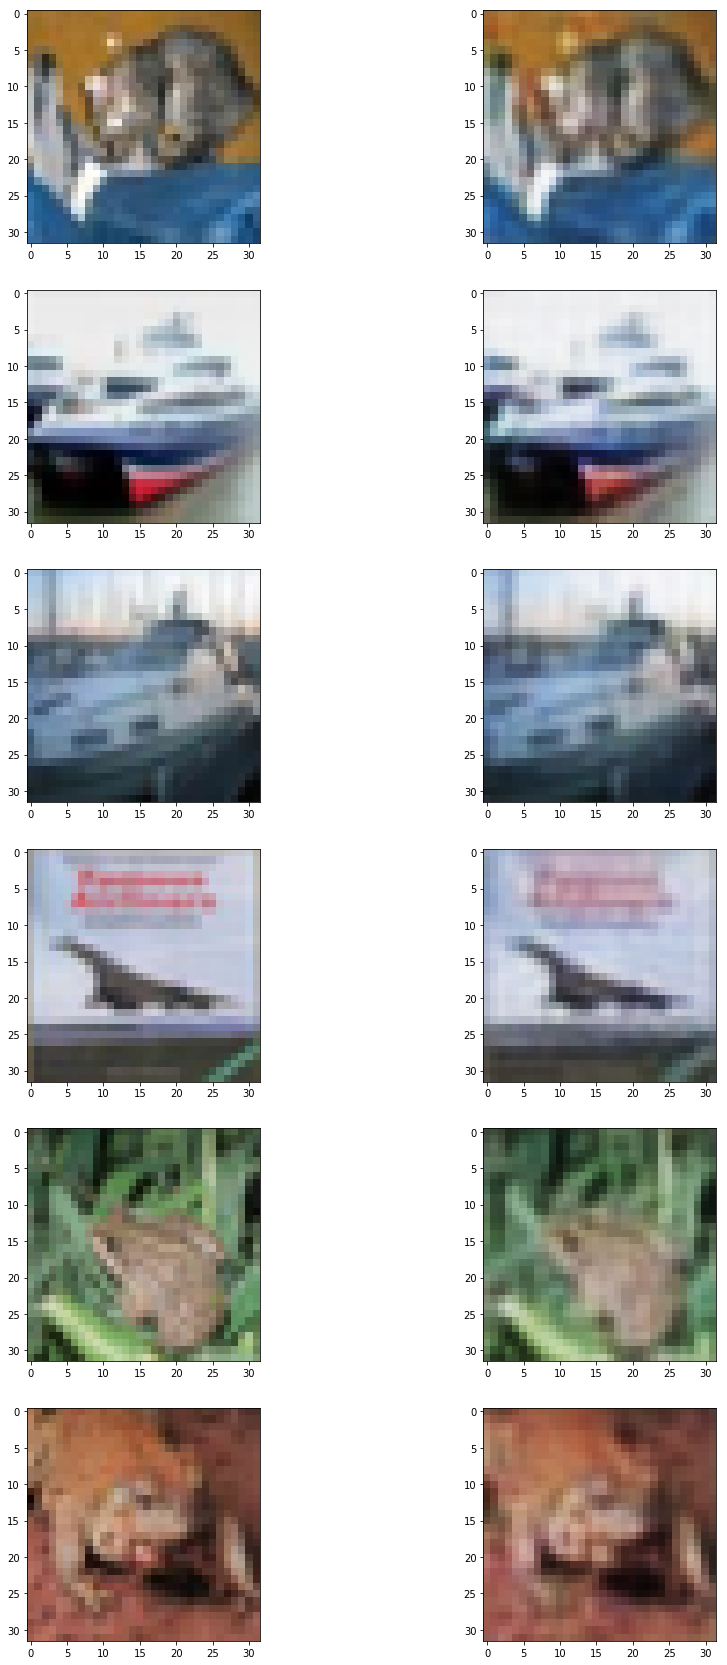

In [5]:
predictions = autoencoder.predict(x_test)

n_examples = 6
fig, axes = plt.subplots(nrows=n_examples,ncols=2, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(predictions[i])
plt.show()

Encode the data set

In [6]:
encoder = Model(input_img, encoded)
encoded_images_train = encoder.predict(x_train)
encoded_images_test = encoder.predict(x_test)

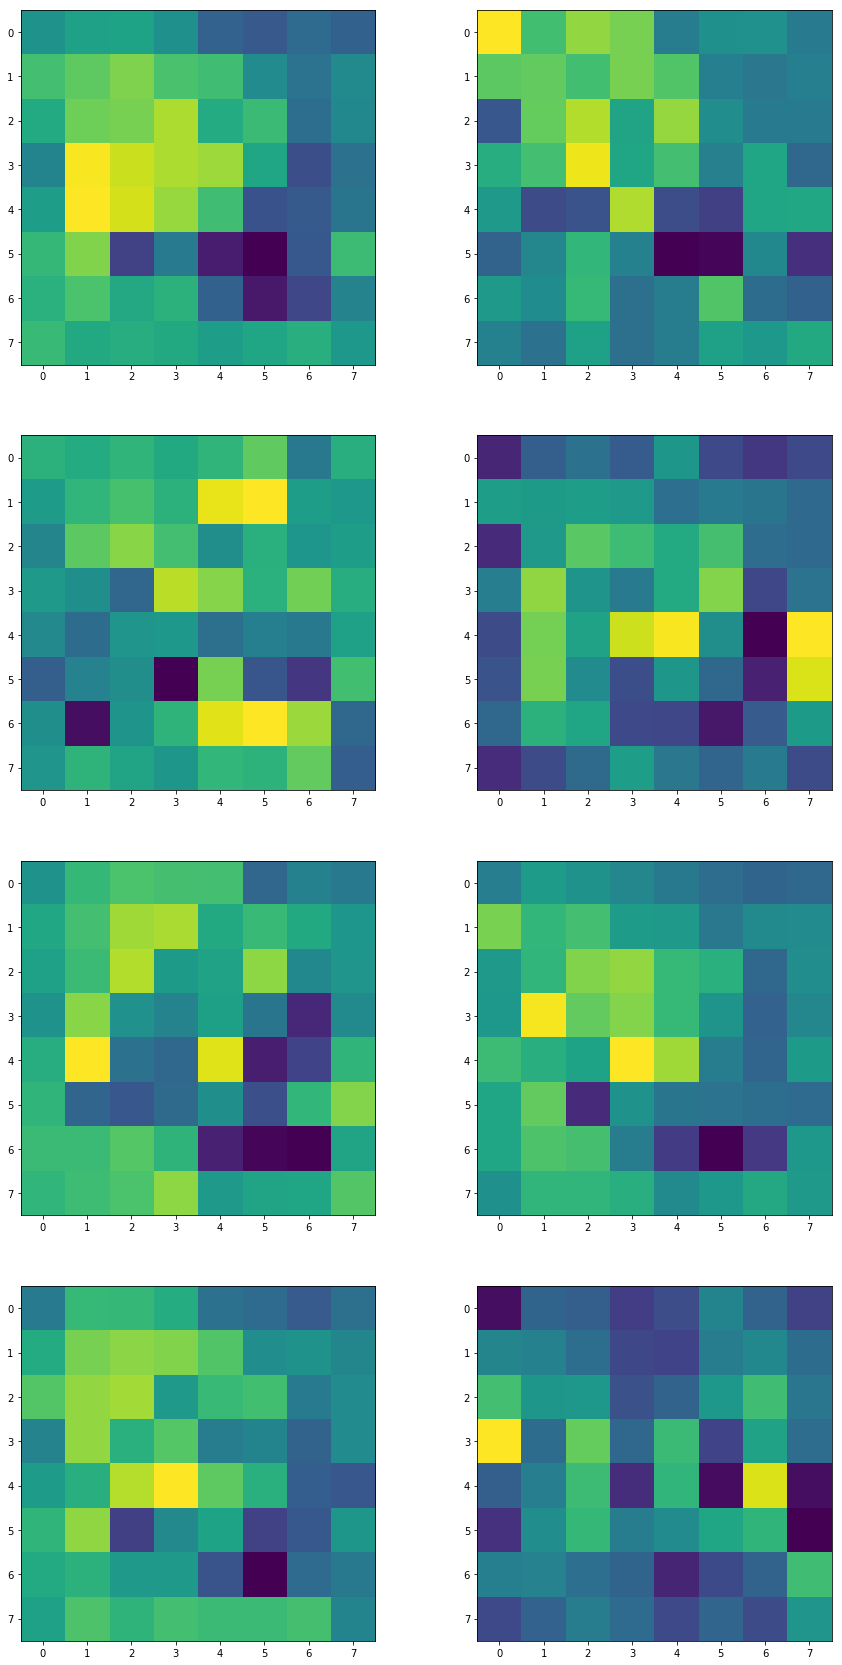

[[2.0626106  2.2179234  2.2394028  2.039942   1.559613   1.4726515
  1.6480592  1.5526458 ]
 [2.5460114  2.6777506  2.81636    2.5790544  2.5222807  1.9870232
  1.7350966  1.9727057 ]
 [2.3142803  2.7415566  2.784015   2.9971352  2.323728   2.4978592
  1.6829212  1.9487424 ]
 [1.9090941  3.282336   3.1035082  2.9911861  2.934198   2.2690935
  1.3714105  1.7163517 ]
 [2.1810253  3.3058863  3.1418402  2.9180229  2.5252554  1.3979503
  1.4803964  1.752492  ]
 [2.452452   2.8191843  1.253647   1.8185648  0.9540426  0.76083905
  1.4658563  2.5060189 ]
 [2.3827744  2.5811815  2.2969317  2.392599   1.5553824  0.93883204
  1.3035402  1.900382  ]
 [2.4748933  2.3078444  2.3504345  2.310197   2.1802075  2.252843
  2.3555586  2.1158423 ]]


In [7]:
example_id = 5
n_examples = int(encoded_images_test.shape[3]/2)
fig, axes = plt.subplots(nrows=n_examples,ncols=2, figsize=(15,30))
for j in range(encoded_images_test.shape[3]):
    axes[int(j/2)][j%2].imshow(encoded_images_test[example_id,:,:,j])
plt.show()
print(encoded_images_test[example_id,:,:,0])

Implement and train a classifier on the encoded data.

In [8]:
#classifier = Sequential()
input_classifier = Input(shape=(encoded_images_train.shape[1:]))
classifier_conv1 = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(input_classifier)
classifier_conv2 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(classifier_conv1)
flattened_classifier = Flatten()(classifier_conv1)
dense_classifier1 = Dense(512, activation='relu')(flattened_classifier)
dropout_classifier1 = Dropout(0.3)(dense_classifier1)
dense_classifier2 = Dense(256, activation='relu')(dropout_classifier1)
dense_classifier3 = Dense(10, activation='softmax')(dense_classifier2)

classifier = Model(input_classifier, dense_classifier3)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.fit(encoded_images_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

classifier.evaluate(encoded_images_test, y_test)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 8s 168us/step - loss: 1.7053 - acc: 0.3828 - val_loss: 1.4916 - val_acc: 0.4578
Epoch 2/20
45000/45000 [==============================] - 6s 132us/step - loss: 1.4529 - acc: 0.4782 - val_loss: 1.4067 - val_acc: 0.4916
Epoch 3/20
45000/45000 [==============================] - 6s 131us/step - loss: 1.3476 - acc: 0.5186 - val_loss: 1.3725 - val_acc: 0.5188
Epoch 4/20
45000/45000 [==============================] - 7s 149us/step - loss: 1.2597 - acc: 0.5498 - val_loss: 1.3456 - val_acc: 0.5174
Epoch 5/20
45000/45000 [==============================] - 6s 134us/step - loss: 1.1875 - acc: 0.5772 - val_loss: 1.2560 - val_acc: 0.5576
Epoch 6/20
45000/45000 [============================

[1.6217143804550171, 0.5683]

Add noise to the images and use the autoencoder as a denoiser to predict the original images from the noisy images (sigma = 0.06, reconstruction error <= 0.0025)

In [9]:
sigma = 0.06
noise = sigma*np.random.randn(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])

x_train_noised = x_train + noise
x_train_noised = np.clip(x_train_noised, a_min=0, a_max=1)

noise = sigma*np.random.randn(x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3])
x_test_noised = x_test + noise
x_test_noised = np.clip(x_test_noised, a_min=0, a_max=1)

autoencoder.fit(x_train_noised, x_train, epochs=20, batch_size=64, validation_split=0.1)

denoised_predictions = autoencoder.predict(x_test_noised)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 42s 937us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 2/20
45000/45000 [==============================] - 41s 909us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/20
45000/45000 [==============================] - 41s 903us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/20
45000/45000 [==============================] - 41s 902us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/20
45000/45000 [==============================] - 43s 945us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/20
45000/45000 [==============================] - 42s 931us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/20
45000/45000 [==============================] - 42s 932us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/20
45000/45000 [==============================] - 42s 927us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/20
45000/45000 [==============================] - 42s 930us/step - loss: 0.0018 - val_l

Visualise the noise-less images, the noisy images and the reconstructed images

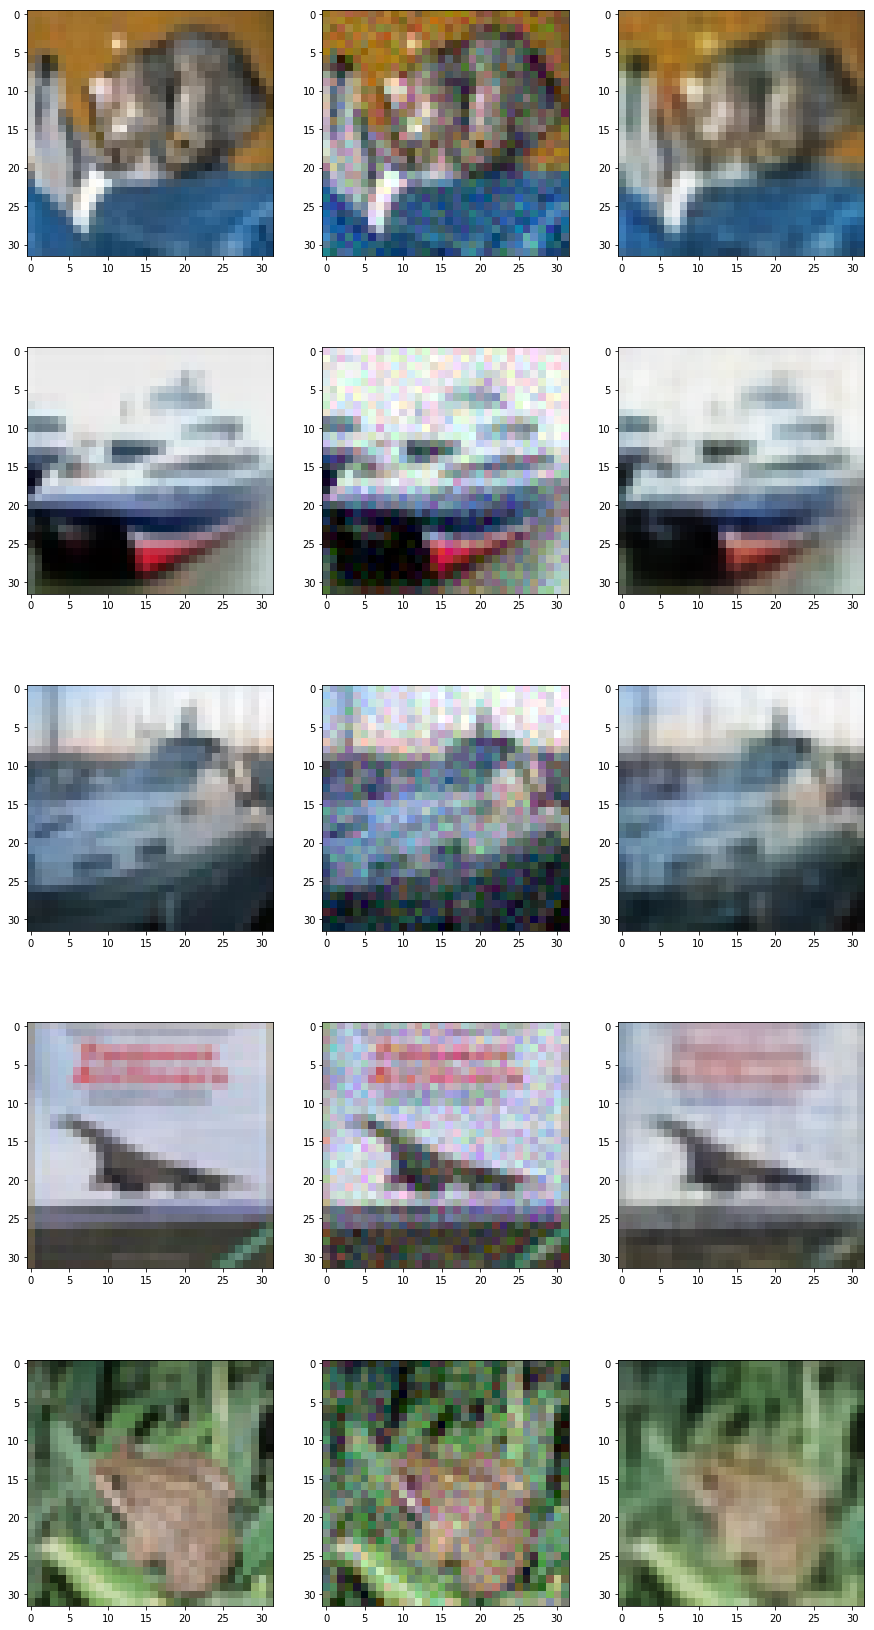

In [10]:
n_examples = 5
fig, axes = plt.subplots(nrows=n_examples,ncols=3, figsize=(15,30))
for i in range(n_examples):
    axes[i][0].imshow(x_test[i])
    axes[i][1].imshow(x_test_noised[i])
    axes[i][2].imshow(denoised_predictions[i])
plt.show()